In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports and library installation
!pip install transformers
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

!pip install keybert
from keybert import KeyBERT

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import re

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import train_test_split


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# New Section

In [ ]:
# Confirm that we are using GPU's which will speed up our processing
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
assert num_gpus_available > 0

Num GPUs Available:  1


In [ ]:
# Load the dataset 
ds = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', split='train', shuffle_files=True)
df = tfds.as_dataframe(ds)
assert isinstance(ds, tf.data.Dataset)

INFO:absl:Load dataset info from /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0
INFO:absl:Reusing dataset amazon_us_reviews (/root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0


In [ ]:
df.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine,Sentiment,short_review,product_id,product_parent,product_title
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1,0,Does not work,B00D1847NE,274617424,Teenage Mutant Ninja Turtles Boombox CD Player...
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1,1,This is a great wiring kit i used it to set up...,B00KMO6DYG,397452138,4 Gauge Amp Kit Amplifier Install Wiring Compl...
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1,1,It works great so much faster than USB charger...,B000GWLL0K,948304826,Travel Wall Charger fits Creative Zen Vision /...
3,b'27389005',0,b'US',b'Mobile_Electronics',b'B008L3JE6Y',b'466340015',b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'2013-07-30',b'camera stand',b'R1TWVUDOFJSQAW',5,0,0,1,1,This product was purchased to hold a monitor o...,B008L3JE6Y,466340015,High Grade Robust 360° Adjustable Car Windshie...
4,b'2663569',0,b'US',b'Mobile_Electronics',b'B00GHZS4SC',b'350592810',b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'2014-12-31',b'bad sound quality',b'R2PEOEUR1LP0GH',3,0,0,1,1,it works but it has really bad sound quality. ...,B00GHZS4SC,350592810,HDE Multifunctional Bluetooth FM Audio Car Kit...


In [ ]:
# Create a feature that indicates if a review has a good user rating
df["Sentiment"] = df["data/star_rating"].apply(lambda score: 1 if score >= 3 else 0)

# Clean data types
df['short_review'] = df['data/review_body'].str.decode("utf-8")
df['product_id'] = df['data/product_id'].str.decode("utf-8")
df['product_parent'] = df['data/product_parent'].str.decode("utf-8")
df['product_title'] = df['data/product_title'].str.decode("utf-8")
df['rating'] = df['data/star_rating']

In [ ]:
# Drop unneeded features
df = df[["short_review",  "Sentiment",  'product_id', 'product_parent', 'product_title', 'rating']]

In [ ]:
# Load tokenizer model for tokenizing review text
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
import os

# This function loads and primes a pre-trained Bert model to predict the attention of amazon reviews based on their ratings 
def load_and_prime_bert_attention_model(df):
  # If a primed model already is saved, load it instead of re-training the model
  if os.path.isfile("./sentiment/tf_model.h5"):
    return TFDistilBertForSequenceClassification.from_pretrained("./sentiment", output_attentions=True)
  else:
    # Create a subset of the data to prime the pre-trained bert model 
    df_subset = df.head(25000)
    reviews = df_subset['short_review'].values.tolist()
    labels = df_subset['Sentiment'].tolist()
    training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(reviews, labels, test_size=.2)

    # Tokenize training and testing data
    train_encodings = tokenizer(training_sentences, truncation=True, padding=True)
    val_encodings = tokenizer(validation_sentences, truncation=True, padding=True)

    # Create the training and testing datasets from the encoded data and their corresponding rating labels
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        training_labels
    ))
    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        validation_labels
    ))

    # Load the pre-trained bert model
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    # Prime the model with review data to make it work for our purposes
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
    model.fit(train_dataset.shuffle(100).batch(16),
              epochs=2,
              batch_size=16,
              validation_data=val_dataset.shuffle(100).batch(16))
    
    # Save the model for future use
    model.save_pretrained("./sentiment")
    return model

In [ ]:
# Get models for analysis
attention_model = load_and_prime_bert_attention_model(df)
keyword_model = KeyBERT()

Some layers from the model checkpoint at ./sentiment were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./sentiment and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
## Define helper functions for classifications for created models

# Gets the attention value of a review using the bert model primed above
def get_attention_value(input, model):
  predict_input = tokenizer.encode(input,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

  outputs = model.predict(predict_input)
  attention_vectors = []
  for layer in outputs.attentions:
    X = layer.flatten()
    attention_vectors.append(X)
  attention_vectors = np.array(attention_vectors)
  attention_vectors = np.mean(attention_vectors)
  return attention_vectors

# Gets review keywords using the pretrained bert model
def get_keywords(input, model):
  keywords = model.extract_keywords(input, keyphrase_ngram_range=(1, 3), stop_words='english',top_n=2)
  if len(keywords) > 0:
    return keywords[0][0]
  else:
    return 'None'

In [ ]:
from time import time

# Define what data we want to run analysis on
project_data = df.head(10000000)

In [ ]:
# Get the keyword for each review
start = time()
project_data['keyword'] = project_data["short_review"].apply(lambda x: get_keywords(x, keyword_model))

time_elapsed = time() - start
m, s = divmod(time_elapsed, 60)
h, m = divmod(m, 60)
print("Hours: " + str(h))
print("Minutes: " + str(m))
print("Seconds: " + str(s))

Hours: 0.0
Minutes: 59.0
Seconds: 29.22889018058777


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Get the attention for each review
start = time()
project_data['attention'] = project_data["keyword"].apply(lambda x: get_attention_value(x, attention_model))

time_elapsed = time() - start
m, s = divmod(time_elapsed, 60)
h, m = divmod(m, 60)
print("Hours: " + str(h))
print("Minutes: " + str(m))
print("Seconds: " + str(s))

Hours: 1.0
Minutes: 23.0
Seconds: 52.25778079032898


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Display results
project_data.head()

,short_review,Sentiment,product_id,product_parent,product_title,rating,keyword,attention
0,Does not work,0,B00D1847NE,274617424,Teenage Mutant Ninja Turtles Boombox CD Player...,1,does work,0.250000
1,This is a great wiring kit i used it to set up...,1,B00KMO6DYG,397452138,4 Gauge Amp Kit Amplifier Install Wiring Compl...,4,power cord length,0.200000
2,It works great so much faster than USB charger...,1,B000GWLL0K,948304826,Travel Wall Charger fits Creative Zen Vision /...,5,faster usb charger,0.166667
3,This product was purchased to hold a monitor o...,1,B008L3JE6Y,466340015,High Grade Robust 360° Adjustable Car Windshie...,5,security camera,0.250000
4,it works but it has really bad sound quality. ...,1,B00GHZS4SC,350592810,HDE Multifunctional Bluetooth FM Audio Car Kit...,3,bass doesn work,0.200000


In [ ]:
# Tokenize key phrases so they can be clustered 
keywords = project_data['keyword'].tolist()

# Create frame to cluster
attention = project_data[['attention']]
embeded_keywords = pd.DataFrame(tokenizer(keywords, truncation=True, padding=True)['input_ids'])
clustering_data = pd.concat([attention, embeded_keywords], axis=1)

# Save what we have so far just in case
backup = pd.concat([project_data, clustering_data], axis=1)
backup.to_csv("./drive/MyDrive/backup_results.csv",index=False)

# Display data
clustering_data.head()

,attention,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.250000,101,2515,2147,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.200000,101,2373,11601,3091,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.166667,101,5514,18833,3715,2099,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.250000,101,3036,4950,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.200000,101,3321,2987,2147,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Clustering and finding the optimal number of clusters
cluster_step = 25
X = clustering_data
maximum_number_of_clusters = int(X.shape[0]/4)
davies_boulding_scores = []

for num_clusters in range(cluster_step, maximum_number_of_clusters, cluster_step):
  k_means = KMeans(n_clusters=num_clusters)
  labels = k_means.fit_predict(X)
  db_index = davies_bouldin_score(X, labels)
  davies_boulding_scores.append(db_index)

plt.plot(list(i * cluster_step for i in range(1, len(davies_boulding_scores)+1)), davies_boulding_scores)
plt.show()

50
100
200
450
750
1000


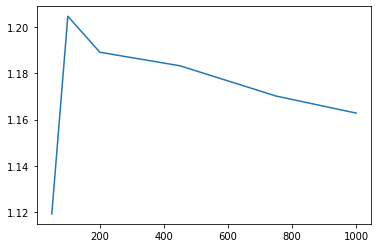

In [4]:
# Clustering and finding the optimal number of clusters (using backedup data)
project_data = pd.read_csv('./backup_results.csv')
project_data.head()

X = project_data[["attention",  "0",  '1', '2', '3', '4', '5', '6', '7', '8']]

cluster_sizes = [50, 100, 200, 450, 750, 1000]
davies_boulding_scores = []

for num_clusters in cluster_sizes:
  print(num_clusters)
  k_means = KMeans(n_clusters=num_clusters)
  labels = k_means.fit_predict(X)
  db_index = davies_bouldin_score(X, labels)
  davies_boulding_scores.append(db_index)

plt.plot(cluster_sizes, davies_boulding_scores)
plt.show()

In [8]:
# Determine the optimal number of clusters
optimal_number_of_clusters = cluster_sizes[davies_boulding_scores.index(min(davies_boulding_scores[1:]))]
print(optimal_number_of_clusters)

1000


In [ ]:
# Cluster Again
k_means = KMeans(n_clusters=optimal_number_of_clusters)
labels = k_means.fit_predict(X)

In [ ]:
# Save the cluster results
pickle.dump(k_means, open("./k_means.pickle", "wb"))

In [ ]:
# Put each product into a cluster
project_data['label'] = labels
project_data.head()

,short_review,Sentiment,product_id,product_parent,product_title,rating,keyword,attention,attention.1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,label
0,Does not work,0,B00D1847NE,274617424,Teenage Mutant Ninja Turtles Boombox CD Player...,1,does work,0.250000,0.250000,101,2515,2147,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,This is a great wiring kit i used it to set up...,1,B00KMO6DYG,397452138,4 Gauge Amp Kit Amplifier Install Wiring Compl...,4,power cord length,0.200000,0.200000,101,2373,11601,3091,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,It works great so much faster than USB charger...,1,B000GWLL0K,948304826,Travel Wall Charger fits Creative Zen Vision /...,5,faster usb charger,0.166667,0.166667,101,5514,18833,3715,2099,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,This product was purchased to hold a monitor o...,1,B008L3JE6Y,466340015,High Grade Robust 360° Adjustable Car Windshie...,5,security camera,0.250000,0.250000,101,3036,4950,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,it works but it has really bad sound quality. ...,1,B00GHZS4SC,350592810,HDE Multifunctional Bluetooth FM Audio Car Kit...,3,bass doesn work,0.200000,0.200000,101,3321,2987,2147,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Export cluster results
X_export = project_data.reset_index()
X_export = project_data[["attention", "Sentiment", "product_id", "product_title", "rating", "keyword", "label"]]

X_export.to_csv("cluster.csv",index=False)
X_export.to_json("cluster.json")

In [ ]:
# Number of products per cluster
X_export['label'].value_counts()

1    50642
3    16534
4    16371
0    14948
2     6480
Name: label, dtype: int64

In [ ]:
# Products in a cluster
filter = X_export[X_export['label'] == 0]
filter.head()

,attention,Sentiment,product_id,product_title,rating,keyword,label
7,0.200000,0,B0050FXF52,Mini GPS Receiver + Location Finder with Displ...,2,inaccurate indicating direction,0
17,0.200000,1,B00J46XO9U,"iXCC Lightning Cable 3ft, iPhone charger, for ...",5,cables regularly problem,0
27,0.200000,1,B008Y6LG8W,MiniGuard Samsung Galaxy Note 10.1 Inch Tablet...,5,blur figure print,0
34,0.111111,1,B004SCD8BE,Instapark® SML-05 PWM 5 Amp Solar Power Charge...,4,jumpers configure charging,0
40,0.200000,1,B00AJ66P9K,PureGear Car Charger For Apple iPhone 5 and iP...,4,ipad fourth gen,0


In [ ]:
X_export.to_csv("./drive/MyDrive/cluster.csv",index=False)
X_export.to_json("./drive/MyDrive/cluster.json")

In [ ]:
pickle.dump(k_means, open("./drive/MyDrive/k_means.pickle", "wb"))

In [ ]:
pickle.dump(k_means, open("./drive/MyDrive/k_means.pickle", "wb"))
X_export.to_csv("./drive/MyDrive/cluster.csv",index=False)
X_export.to_json("./drive/MyDrive/cluster.json")